In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
import random, math
import numpy as np
import networkx as nx
from collections import defaultdict
from itertools import product
from functools import reduce
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import array_to_latex, plot_histogram
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'
seed(None)

In [2]:
data = pd.read_csv("./datasets/heroes/hero-network.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [4]:
data.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [5]:
heroes = [
 'MEDUSA/MEDUSALITH AM',
 'ARCLIGHT/PHILLIPA SO',
 'WOLVERINE/LOGAN ',
 'SCARLET WITCH/WANDA ',
 #'ARAGORN',
 'OVERMIND/GROM',
 'BATTLEAXE/',
 'ION/',
 'PINK PEARL/'
]

In [6]:
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]

In [7]:
relations = pd.DataFrame(np.sort(relations.values, axis = 1), columns = relations.columns).drop_duplicates(subset = ['hero1', 'hero2'])

In [8]:
relations.head()

,hero1,hero2
0,SCARLET WITCH/WANDA,WOLVERINE/LOGAN
4,MEDUSA/MEDUSALITH AM,WOLVERINE/LOGAN
5,MEDUSA/MEDUSALITH AM,SCARLET WITCH/WANDA
6,OVERMIND/GROM,SCARLET WITCH/WANDA
27,ARCLIGHT/PHILLIPA SO,WOLVERINE/LOGAN


In [9]:
graph = nx.from_pandas_edgelist(relations, source = 'hero1', target = 'hero2')

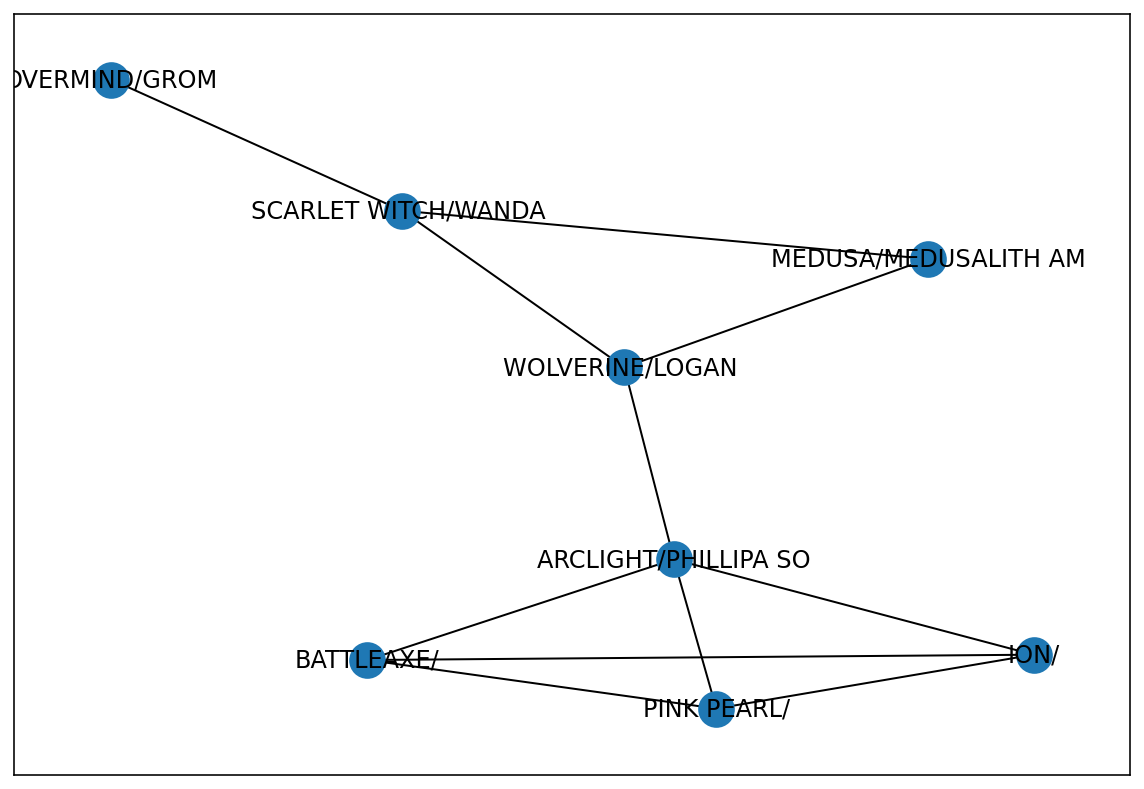

In [10]:
nx.draw_networkx(graph)

In [11]:
matrix = nx.to_pandas_adjacency(graph, dtype = int)

In [12]:
matrix

,SCARLET WITCH/WANDA,WOLVERINE/LOGAN,MEDUSA/MEDUSALITH AM,OVERMIND/GROM,ARCLIGHT/PHILLIPA SO,ION/,BATTLEAXE/,PINK PEARL/
SCARLET WITCH/WANDA,0,1,1,1,0,0,0,0
WOLVERINE/LOGAN,1,0,1,0,1,0,0,0
MEDUSA/MEDUSALITH AM,1,1,0,0,0,0,0,0
OVERMIND/GROM,1,0,0,0,0,0,0,0
ARCLIGHT/PHILLIPA SO,0,1,0,0,0,1,1,1
ION/,0,0,0,0,1,0,1,1
BATTLEAXE/,0,0,0,0,1,1,0,1
PINK PEARL/,0,0,0,0,1,1,1,0


In [13]:
PAULIS = {
    "I" : np.eye(2, dtype = complex),
    "X" : np.array([[0, 1], [1, 0]], dtype = complex),
    "Y" : np.array([[0, -1j], [1j, 0]], dtype = complex),
    "Z" : np.array([[1, 0], [0, -1]], dtype = complex)
}

def pauli_decomposition(H):

    n = int(math.log2(len(H)))
    dims = 2 ** n

    components = defaultdict(int)

    keys = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]

    for i, val in enumerate(product(PAULIS.values(), repeat = n)):

        basis_mat = reduce(np.kron, val)

        coeff = np.dot(H.reshape(-1), basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()

        if not np.allclose(coeff, 0):
            components[keys[i]] = coeff
            
    return components
      
def ansatz(qc, qr, thetas, rounds = 3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r * len(qr) * 2 + i * 2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset + 1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i - 1], qr[i])
    return qc

def matrix_decomposition_circuits(H, add_ansatz):
    
    n = int(np.log2(len(H)))
    dims = 2 ** n
    
    if H.shape != (dims, dims):
        raise ValueError("The imput must be a 2^n x 2^n dimensional matrix.")
        
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, 'qr')
        cr = ClassicalRegister(1, 'cr')
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)
        
        if all(x[1] == "I" for x in paulis):
            circuits[paulistring] = (qc, weight)
            continue
            
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx + 1] = (paulis[idx + 1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
                
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits

def run_circuit(circuit, backend, shots = 10000):
    result = execute(circuit, backend, shots = shots).result()

    counts = result.get_counts()

    return (
        (counts['0'] if '0' in counts.keys() else 0) - (counts['1'] if '1' in counts.keys() else 0)
    )/shots

def expectation(H, rounds, thetas):
    backend = Aer.get_backend('statevector_simulator')
    circuits = matrix_decomposition_circuits(
        H,
        lambda qc, qr: ansatz(qc, qr, thetas, rounds)
    )
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend) * circuits[key][1], circuits.keys()))

# Variational Quantum Eigensolver
def vqe(H, rounds, max_iter, thetas = None, save_steps = None):
    
    cnt_qubits = int(np.log2(len(H)))
    
    if thetas is None:
        thetas = list(map(
            lambda x: random.random(),
            [0] * ((1 + rounds) * cnt_qubits * 2)
        ))
        
    optimizer = SPSA(
        a = 0.9,
        c = 1.0,
        A = max_iter / 10,
        alpha = 0.6,
        gamma = 0.1,
        loss_function = lambda t_thetas: expectation(H, rounds, t_thetas)
    )
    
    for i in range(max_iter):

        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield(i, thetas, expectation(H, rounds, thetas))
    
    return (thetas, expectation(H, rounds, thetas))

In [14]:
# Create an optimizer, SPSA
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, loss_function):
        
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function
        
        self.t = 0
        
    def step(self, current_estimate):
        
        a_t = self.a / (self.t + 1 + self.A) ** self.alpha
        c_t = self.c / (self.t + 1) ** self.gamma
        
        delta = np.random.randint(0, 2, np.array(current_estimate).shape) * 2 - 1
        
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        current_estimate = current_estimate - a_t * g_t
        
        self.t += 1
        
        return current_estimate

In [15]:
H = matrix.to_numpy()
array_to_latex(H, prefix = "H = ")

<IPython.core.display.Latex object>

In [16]:
result = None
step_size = 3

for step in vqe(H, rounds = 3, max_iter = 60, save_steps = step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step = step[0], ev = step[2]))
    result = step
    
print("The solution is:\n " + str(result[1]))
print('The lowest expectation value is: {ev: .3f}'.format(ev = result[2]))

Step 0. Current expectation value:  0.336
Step 3. Current expectation value:  0.132
Step 6. Current expectation value: -0.336
Step 9. Current expectation value: -0.452
Step 12. Current expectation value: -0.475
Step 15. Current expectation value: -0.653
Step 18. Current expectation value: -0.677
Step 21. Current expectation value: -0.526
Step 24. Current expectation value: -0.842
Step 27. Current expectation value: -0.936
Step 30. Current expectation value: -1.022
Step 33. Current expectation value: -1.130
Step 36. Current expectation value: -1.107
Step 39. Current expectation value: -1.101
Step 42. Current expectation value: -1.116
Step 45. Current expectation value: -1.161
Step 48. Current expectation value: -1.253
Step 51. Current expectation value: -1.281
Step 54. Current expectation value: -1.254
Step 57. Current expectation value: -1.285
The solution is:
 [-0.65266029  0.73718632  1.39367375  0.70196045  0.96001716  1.149681
  0.40416324 -0.73399803  0.23535634 -0.47147353  0.714

In [17]:
# Create Ising hamiltonian
def tensor_product(qubits, node1, node2):
    
    qc = QuantumCircuit(qubits)
    
    qc.z(node1)
    qc.z(node2)
    
    backend = Aer.get_backend('unitary_simulator')
    result = execute(qc, backend).result()
    
    edge = result.get_unitary()
    
    return np.array(edge, dtype = complex)

In [18]:
# test
H = tensor_product(3, 0, 1) + tensor_product(3, 1, 2)

array_to_latex(H, prefix = "H = ")

<IPython.core.display.Latex object>

In [19]:
thetas = None
step_size = 10
steps = []
evs = []

for step in vqe(H, rounds = 3, max_iter = 200, save_steps = step_size):
    steps = steps + [step[2]]
    evs = evs + [step[0]]
    thetas = step[1]
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step = step[0], ev = step[2]))
    
print('The solution is: [\n'
     + "".join(["\t" + str(round(t, 3))
    + ",\n" if i % 3 == 2 else "\t" + str(round(t, 3))
    + ",\t" for i, t in enumerate(thetas)]) + "]")

print('The lowest expectation value is: {ev: .3f}'.format(ev = steps[-1]))

Step 0. Current expectation value:  0.769
Step 10. Current expectation value:  0.757
Step 20. Current expectation value:  0.640
Step 30. Current expectation value:  0.482
Step 40. Current expectation value: -0.141
Step 50. Current expectation value: -0.459
Step 60. Current expectation value: -0.632
Step 70. Current expectation value: -0.979
Step 80. Current expectation value: -1.040
Step 90. Current expectation value: -1.343
Step 100. Current expectation value: -1.314
Step 110. Current expectation value: -1.553
Step 120. Current expectation value: -1.700
Step 130. Current expectation value: -1.727
Step 140. Current expectation value: -1.812
Step 150. Current expectation value: -1.833
Step 160. Current expectation value: -1.838
Step 170. Current expectation value: -1.884
Step 180. Current expectation value: -1.897
Step 190. Current expectation value: -1.896
The solution is: [
	0.067,		0.581,		-0.099,
	-0.29,		0.174,		1.638,
	1.424,		0.654,		-0.249,
	0.5,		-0.241,		0.338,
	-0.064,		0.739

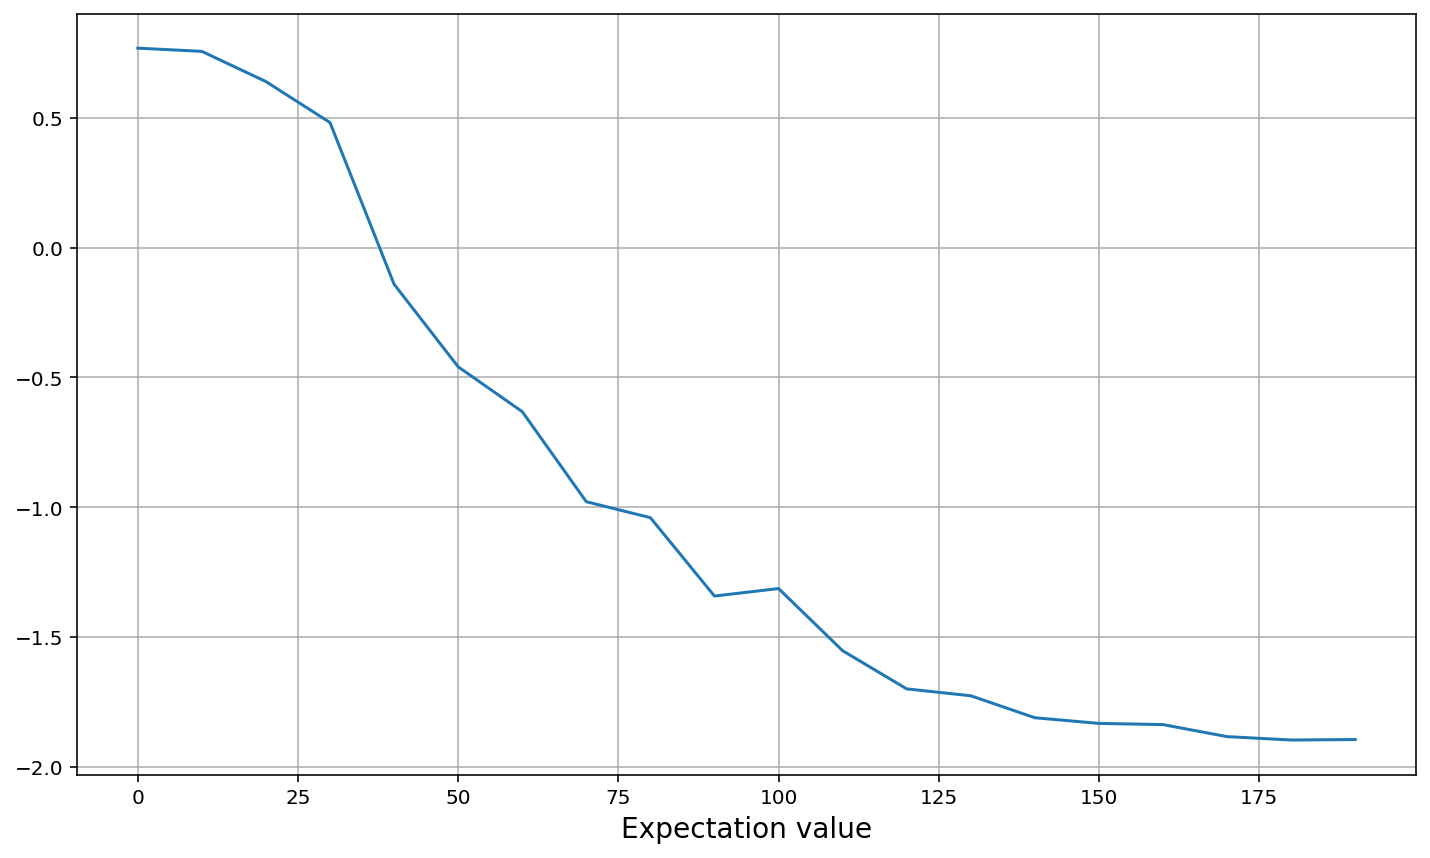

In [20]:
plt.figure(figsize = (12, 7))
plt.plot(evs, steps)

plt.xlabel("Number of executions", fontsize = 14)
plt.xlabel("Expectation value", fontsize = 14)
plt.grid()

plt.show()

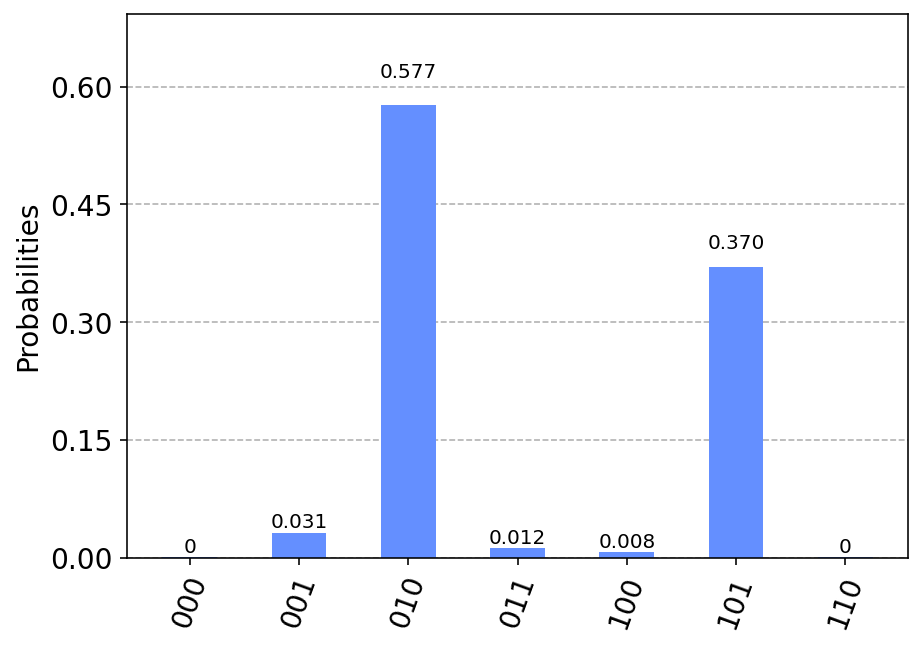

In [21]:
qr = QuantumRegister(3, "qr")
cr = ClassicalRegister(3, "cr")

qc = QuantumCircuit(qr, cr)

ansatz(qc, qr, thetas = thetas, rounds = 3)

for i in range(3):
    qc.measure(qr[i], cr[i])
    
backend = Aer.get_backend('qasm_simulator')

result = execute(qc, backend).result()
counts = result.get_counts()

plot_histogram(counts)

In [22]:
max_count = max(counts, key = counts.get)
print("Combination with smallest eigenvalue: " + max_count)

Combination with smallest eigenvalue: 010


In [23]:
# Move back to superheroes data
ordered_heroes = {hero : pos for pos, hero in enumerate(list(heroes))}
ordered_heroes

{'MEDUSA/MEDUSALITH AM': 0,
 'ARCLIGHT/PHILLIPA SO': 1,
 'WOLVERINE/LOGAN ': 2,
 'SCARLET WITCH/WANDA ': 3,
 'OVERMIND/GROM': 4,
 'BATTLEAXE/': 5,
 'ION/': 6,
 'PINK PEARL/': 7}

In [24]:
H = sum(
        map(
            lambda row: tensor_product(
                len(ordered_heroes),
                ordered_heroes[row[1]["hero1"]],
                ordered_heroes[row[1]["hero2"]]
            ),
            relations.iterrows()
        )
)

In [25]:
array_to_latex(H, prefix = "H = ")

<IPython.core.display.Latex object>

In [26]:
# Very long execution
#
#thetas = None
#step_size = 10
#steps = []
#evs = []

#for step in vqe(H, rounds = 3, max_iter = 200, save_steps = step_size):
#    steps = steps + [step[2]]
#    evs = evs + [step[0]]
#    thetas = step[1]
#    print('Step {step}. Current expectation value: {ev: .3f}'.format(step = step[0], ev = step[2]))
    
#print('The solution is:\n ' + thetas)
#print('The lowest expectation value is: {ev: .3f}'.format(ev = steps[-1]))

In [27]:
#plt.figure(figsize = (12, 7))
#plt.plot(evs, steps)

#plt.xlabel("Number of executions", fontsize = 14)
#plt.xlabel("Expectation value", fontsize = 14)
#plt.grid()

#plt.show()

### VQE and Maxcut problem with Qiskit

In [40]:
import pandas as pd
import networkx as nx
from qiskit_optimization.applications import Maxcut
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import EfficientSU2

In [29]:
data = pd.read_csv("./datasets/heroes/hero-network.csv")

In [30]:
heroes = [
 'MEDUSA/MEDUSALITH AM',
 'ARCLIGHT/PHILLIPA SO',
 'WOLVERINE/LOGAN ',
 'SCARLET WITCH/WANDA ',
 'ARAGORN',
 'OVERMIND/GROM',
 'BATTLEAXE/',
 'ION/',
 'PINK PEARL/'
]

In [31]:
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis = 1), columns = relations.columns).drop_duplicates(subset = ['hero1', 'hero2'])

In [68]:
relations

,hero1,hero2
0,SCARLET WITCH/WANDA,WOLVERINE/LOGAN
4,MEDUSA/MEDUSALITH AM,WOLVERINE/LOGAN
5,ARAGORN,SCARLET WITCH/WANDA
7,MEDUSA/MEDUSALITH AM,SCARLET WITCH/WANDA
8,OVERMIND/GROM,SCARLET WITCH/WANDA
12,ARAGORN,OVERMIND/GROM
32,ARCLIGHT/PHILLIPA SO,WOLVERINE/LOGAN
65,ARCLIGHT/PHILLIPA SO,ION/
66,ARCLIGHT/PHILLIPA SO,BATTLEAXE/
67,ARCLIGHT/PHILLIPA SO,PINK PEARL/


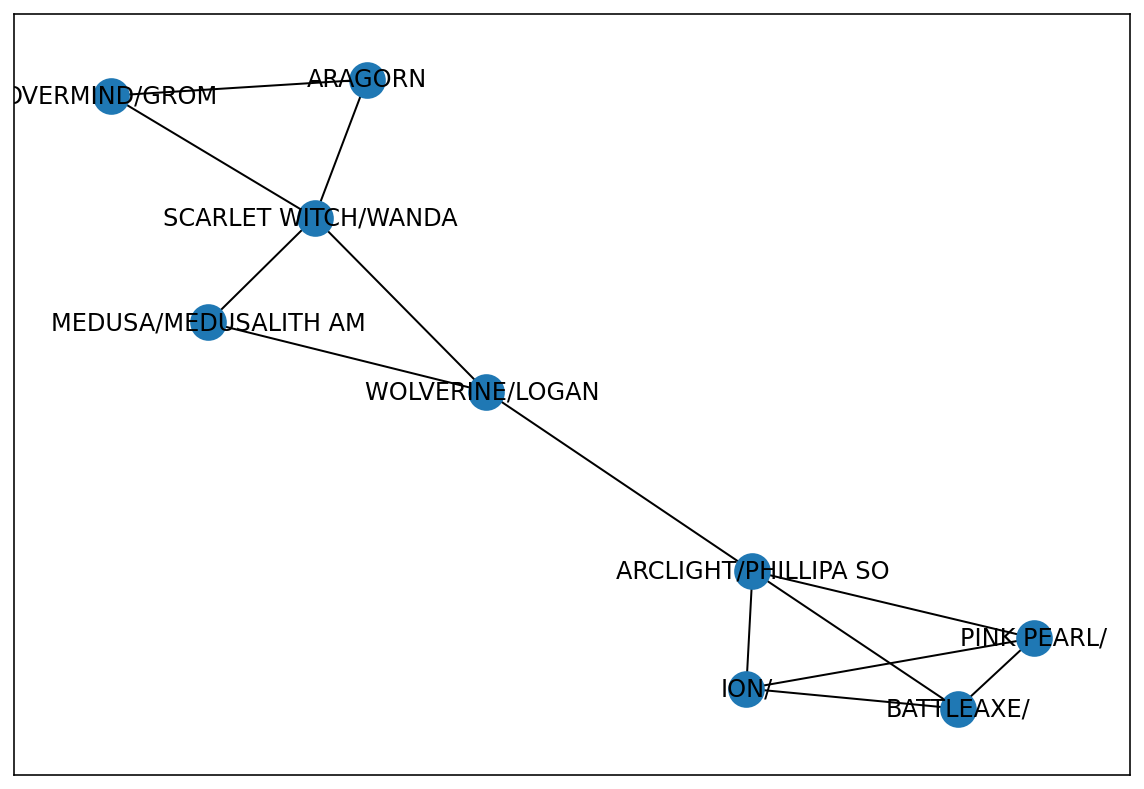

In [32]:
graph = nx.from_pandas_edgelist(relations, source = 'hero1', target = 'hero2')
nx.draw_networkx(graph)

In [33]:
matrix = nx.to_pandas_adjacency(graph, dtype = int)
adjacency = matrix.to_numpy() # Adjacency matrix

In [34]:
max_cut = Maxcut(adjacency)

In [35]:
# Quadratic program to Ising Hamiltonian
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

In [36]:
print("Offset: ", offset)
print("Ising hamiltonian: ")
print(str(qubitOp))

Offset:  -6.5
Ising hamiltonian: 
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZIZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIIZ
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIIZI
+ 0.5 * IIZZIIIII
+ 0.5 * IZIZIIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZIZIIIIII
+ 0.5 * ZZIIIIIII


In [43]:
backend = Aer.get_backend('qasm_simulator')

In [44]:
quantum_instance = QuantumInstance(backend)

In [48]:
# Optimizer
spsa = SPSA(maxiter = 300)

In [49]:
# Solution ansatz
ansatz = EfficientSU2(qubitOp.num_qubits, su2_gates = ['ry', 'rz'], entanglement = 'linear', reps = 3)

In [53]:
# VQE algorithm
vqe = VQE(ansatz, optimizer = spsa, quantum_instance = quantum_instance)

In [54]:
result = vqe.compute_minimum_eigenvalue(qubitOp)

In [56]:
print('Energy: ', result.eigenvalue.real)
print('Time: ', result.optimizer_time)

Energy:  -2.0263671875
Time:  38.008065938949585


In [58]:
solution = max_cut.sample_most_likely(result.eigenstate)

In [61]:
print('Solution: ', solution)
print('Solution opbjective: ', qp.objective.evaluate(solution))

Solution:  [0 1 1 1 0 0 1 0 1]
Solution opbjective:  9.0


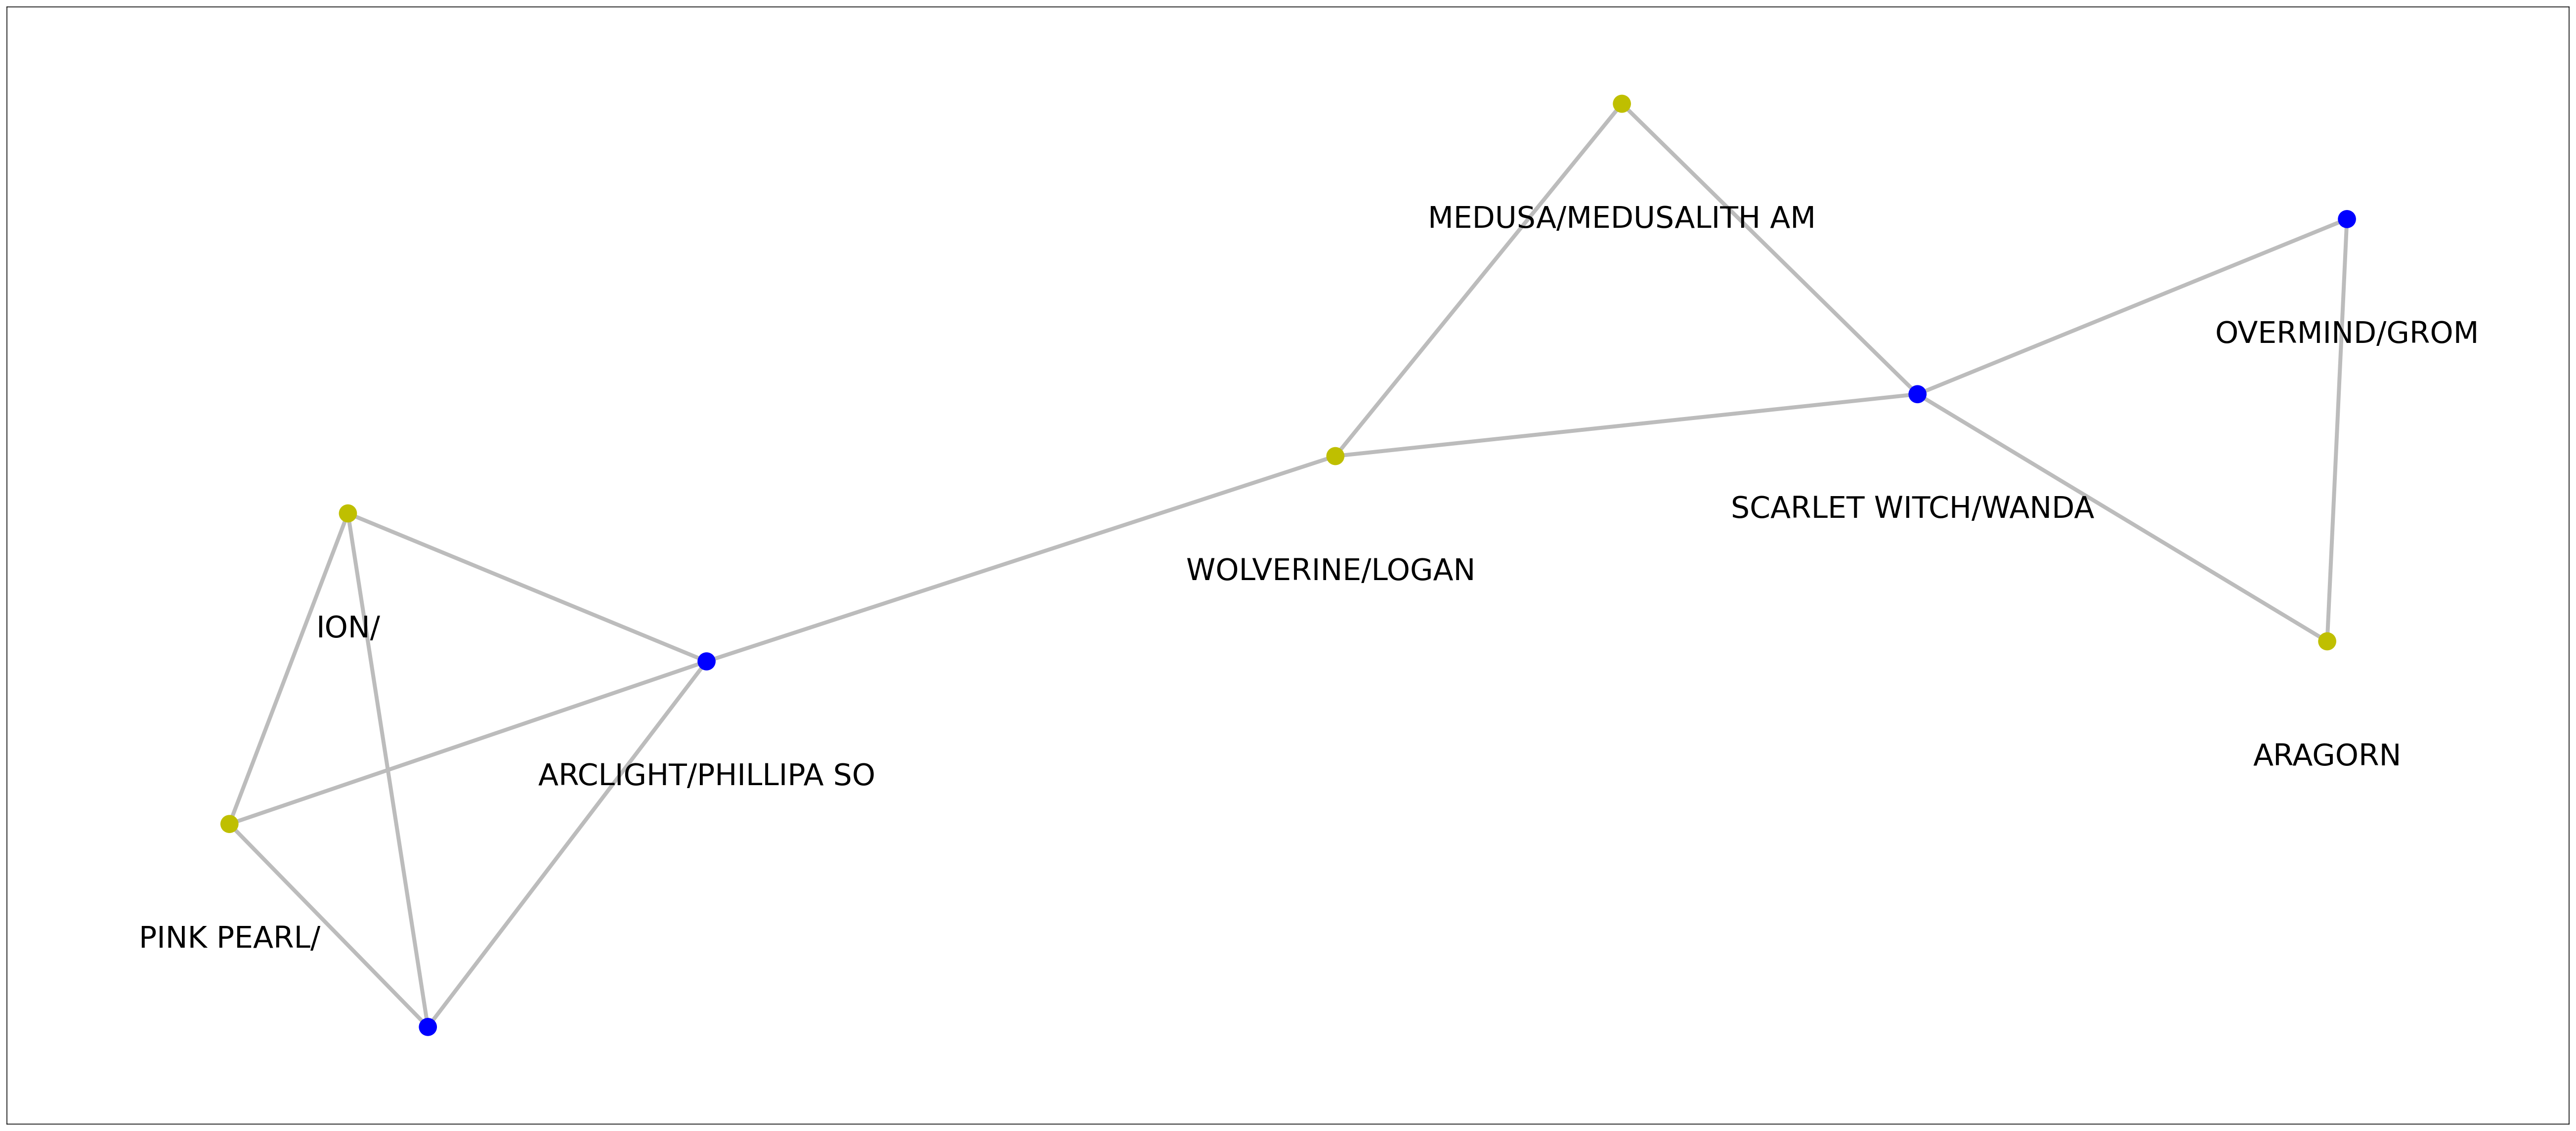

In [79]:
# Plot soluton
plt.figure(1, figsize = (12, 2.5))
plt.tight_layout()
plt.subplots_adjust(bottom = -5.4, right = 1.5, left = -1.5)

def place_labels(pos, x_shift, y_shift):
    return {n: (x + x_shift, y + y_shift) for n, (x, y) in pos.items()}

pos = nx.spring_layout(graph)
pos_nodes = place_labels(pos, 0 , -0.07)

colors = ['b' if solution[i] == 0 else 'y' for i in range(qubitOp.num_qubits)]

nx.draw_networkx_nodes(graph, pos = pos, node_color = colors)
nx.draw_networkx_edges(graph, pos = pos, width = 4, edge_color = "#BCBCBC")

labels = nx.draw_networkx_labels(graph, pos = pos_nodes, font_color = "#000000", font_size = 30)